### Imports

In [1]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
# Values:
# 0 = all logs (default)
# 1 = filter out INFO
# 2 = filter out INFO and WARNING

import joblib, json, time, numpy as np, pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
%load_ext autoreload
%autoreload 2
from scripts import farseeing as fs
from scripts import utils
from scripts.models import get_model_specs
from scripts.model_runner import run_models
from scripts.metric import compute_row, aggregate
from scripts.plotting import metric_grid, metric_box

# Directories
RES_DIR = Path("results"); RES_DIR.mkdir(exist_ok=True)
FIG_DIR = Path("figs"); FIG_DIR.mkdir(exist_ok=True)
CACHE = RES_DIR / "model_cache"; CACHE.mkdir(exist_ok=True)

2025-08-05 22:57:55.206999: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-08-05 22:57:55.207041: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-08-05 22:57:55.207857: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


### Experiment Grid

In [2]:
WINDOW_SIZES = [3, 5, 7, 10, 15, 30, 60] # seconds
MODEL_SPECS = get_model_specs() # all models
# SEEDS = np.random.RandomState(14).choice(
# 	np.arange(10), size=3, replace=False).tolist()
SEEDS = [0, 1, 2] # for reproducibility
CV_FOLDS = 5
WINDOW_FREQ = 100 #Hz
print(f"Random seeds: {SEEDS}")

Random seeds: [0, 1, 2]


### Train/Test Subject Split
To avoid data leakage, we separate some subjects for final testing and use the training set only for cross-validation.

In [3]:
# Load train and test data if available, otherwise compute
try:
	subjects = json.load((open(RES_DIR/"subjects.json", "r")))
	TRAIN_SUBJ = subjects['train']
	TEST_SUBJ = subjects['test']
	print("Loaded train/test subjects from subjects.json")
except FileNotFoundError:
	print("No subjects.json found, computing train/test split...")
	TRAIN_SUBJ, TEST_SUBJ = utils.train_test_subjects_split(
		fs, test_size=0.2, random_state=42)
	json.dump({"train": TRAIN_SUBJ.tolist(), "test": TEST_SUBJ.tolist()},
			  open(RES_DIR/"subjects.json", "w"))

Loaded train/test subjects from subjects.json


### Initial Cross-validation and Window Size Selection

In [4]:
train_df = fs.load().query("SubjectID in @TRAIN_SUBJ")

In [5]:
from scripts.cv_runner import CVRunner

dummy_specs = get_model_specs(kind="baseline")
DUMMY_CV_ROWS = []
kwargs = dict(
	multiphase=True,
	segment_test=False,
	thresh=1.4
)
run_kwargs = dict(
	verbose=True,
    model_specs=dummy_specs,
    ensemble_models=True,         
    ensemble_by_kind=True                  
)

Baseline models

In [ ]:
for win in WINDOW_SIZES:
	print(f"Running CV for window size {win} seconds")
	runner = CVRunner(
        df=train_df,
        dataset=fs,
        groups="SubjectID",
        split_df_fn=utils.split_df,
        run_models_fn=run_models,
        window_size=win,
        cv=CV_FOLDS,
        kwargs=kwargs
    )
	dummy_fold_df = runner.run(**run_kwargs)
	dummy_fold_df["window_size"] = win
	DUMMY_CV_ROWS.append(dummy_fold_df)
dummy_cv_metrics = pd.concat(DUMMY_CV_ROWS, ignore_index=True)
dummy_cv_metrics.to_csv(RES_DIR / "dummy_cv_all_windows.csv", index=False)

Running CV for window size 3 seconds

– Fold 1/5: testing on 7 subjects –
Train set: 102 samples, Test set: 22 samples
Train set: X: (1080, 300), y: (1080,)    ([ADLs, Falls]) [978 102]
Test set: X: 22, y: 22
TRAINING (seed=0) DummyADL. DummyFall. ✅
TESTING DummyADL_0. DummyFall_0. ✅

– Fold 2/5: testing on 7 subjects –
Train set: 87 samples, Test set: 37 samples
Train set: X: (1140, 300), y: (1140,)    ([ADLs, Falls]) [1053   87]
Test set: X: 37, y: 37
TRAINING (seed=0) DummyADL. DummyFall. ✅
TESTING DummyADL_0. DummyFall_0. ✅

– Fold 3/5: testing on 6 subjects –
Train set: 113 samples, Test set: 11 samples
Train set: X: (969, 300), y: (969,)    ([ADLs, Falls]) [856 113]
Test set: X: 11, y: 11
TRAINING (seed=0) DummyADL. DummyFall. ✅
TESTING DummyADL_0. DummyFall_0. ✅

– Fold 4/5: testing on 6 subjects –
Train set: 108 samples, Test set: 16 samples
Train set: X: (1182, 300), y: (1182,)    ([ADLs, Falls]) [1074  108]
Test set: X: 16, y: 16
TRAINING (seed=0) DummyADL. DummyFall. ✅
TESTI

Real models

In [ ]:
ALL_CV_ROWS = []
run_kwargs.update(model_specs=MODEL_SPECS)
models = [spec for spec in MODEL_SPECS\
		  if spec.kind != "baseline"
		  and spec.name != "ResNet"]
run_kwargs.update(model_specs=models)
for win in WINDOW_SIZES:
	print(f"Running CV for window size {win} seconds")
	runner = CVRunner(
        df=train_df,
        dataset=fs,
        groups="SubjectID",
        split_df_fn=utils.split_df,
        run_models_fn=run_models,
        window_size=win,
        cv=CV_FOLDS,
        kwargs=kwargs
    )
	fold_df = runner.run(**run_kwargs)
	fold_df["window_size"] = win
	ALL_CV_ROWS.append(fold_df)
cv_metrics = pd.concat(ALL_CV_ROWS, ignore_index=True)
cv_metrics.to_csv(RES_DIR / "cv_all_windows.csv", index=False)

2025-08-01 14:40:53,593 [INFO] Training models (seed=0)


Running CV for window size 3 seconds

– Fold 1/5: testing on 7 subjects –
Train set: 102 samples, Test set: 22 samples
Train set: X: (1080, 300), y: (1080,)    ([ADLs, Falls]) [978 102]
Test set: X: 22, y: 22


Training (seed=0):  86%|████████▌ | 6/7 [00:05<00:01,  1.18s/it]WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
I0000 00:00:1754059269.375488   24650 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
Evaluating models:  86%|████████▌ | 6/7 [00:28<00:06,  6.59s/it]

19/19 [==============================] - 0s 3ms/step


Evaluating models: 100%|██████████| 7/7 [00:36<00:00,  5.25s/it]
2025-08-01 14:42:38,585 [INFO] ✅ Evaluation complete



– Fold 2/5: testing on 7 subjects –


2025-08-01 14:42:38,645 [INFO] Training models (seed=0)


Train set: 87 samples, Test set: 37 samples
Train set: X: (1140, 300), y: (1140,)    ([ADLs, Falls]) [1053   87]
Test set: X: 37, y: 37


Evaluating models:  86%|████████▌ | 6/7 [00:42<00:10, 10.20s/it]

19/19 [==============================] - 0s 3ms/step


Evaluating models: 100%|██████████| 7/7 [00:50<00:00,  7.16s/it]
2025-08-01 14:44:12,774 [INFO] ✅ Evaluation complete



– Fold 3/5: testing on 6 subjects –


2025-08-01 14:44:12,795 [INFO] Training models (seed=0)


Train set: 113 samples, Test set: 11 samples
Train set: X: (969, 300), y: (969,)    ([ADLs, Falls]) [856 113]
Test set: X: 11, y: 11


Evaluating models:  86%|████████▌ | 6/7 [00:11<00:02,  2.22s/it]

19/19 [==============================] - 0s 3ms/step


Evaluating models: 100%|██████████| 7/7 [00:13<00:00,  1.88s/it]
2025-08-01 14:45:19,257 [INFO] ✅ Evaluation complete
2025-08-01 14:45:19,293 [INFO] Training models (seed=0)



– Fold 4/5: testing on 6 subjects –
Train set: 108 samples, Test set: 16 samples
Train set: X: (1182, 300), y: (1182,)    ([ADLs, Falls]) [1074  108]
Test set: X: 16, y: 16


Evaluating models:  86%|████████▌ | 6/7 [00:18<00:04,  4.29s/it]

19/19 [==============================] - 0s 3ms/step


Evaluating models: 100%|██████████| 7/7 [00:21<00:00,  3.06s/it]
2025-08-01 14:46:55,074 [INFO] ✅ Evaluation complete
2025-08-01 14:46:55,099 [INFO] Training models (seed=0)



– Fold 5/5: testing on 6 subjects –
Train set: 86 samples, Test set: 38 samples
Train set: X: (713, 300), y: (713,)    ([ADLs, Falls]) [627  86]
Test set: X: 38, y: 38


Evaluating models:  86%|████████▌ | 6/7 [00:46<00:10, 10.98s/it]

19/19 [==============================] - 0s 3ms/step


Evaluating models: 100%|██████████| 7/7 [00:56<00:00,  8.00s/it]
2025-08-01 14:48:30,420 [INFO] ✅ Evaluation complete


Running CV for window size 5 seconds

– Fold 1/5: testing on 7 subjects –
Train set: 102 samples, Test set: 22 samples
Train set: X: (1063, 500), y: (1063,)    ([ADLs, Falls])

2025-08-01 14:48:30,492 [INFO] Training models (seed=0)


 [961 102]
Test set: X: 22, y: 22


Evaluating models:  86%|████████▌ | 6/7 [00:36<00:08,  8.69s/it]

19/19 [==============================] - 0s 4ms/step


Evaluating models: 100%|██████████| 7/7 [00:45<00:00,  6.57s/it]
2025-08-01 14:50:44,473 [INFO] ✅ Evaluation complete
2025-08-01 14:50:44,515 [INFO] Training models (seed=0)



– Fold 2/5: testing on 7 subjects –
Train set: 87 samples, Test set: 37 samples
Train set: X: (1124, 500), y: (1124,)    ([ADLs, Falls]) [1037   87]
Test set: X: 37, y: 37


Evaluating models:  86%|████████▌ | 6/7 [00:55<00:13, 13.18s/it]

19/19 [==============================] - 0s 4ms/step


Evaluating models: 100%|██████████| 7/7 [01:02<00:00,  8.91s/it]
2025-08-01 14:52:57,618 [INFO] ✅ Evaluation complete
2025-08-01 14:52:57,639 [INFO] Training models (seed=0)



– Fold 3/5: testing on 6 subjects –
Train set: 113 samples, Test set: 11 samples
Train set: X: (949, 500), y: (949,)    ([ADLs, Falls]) [836 113]
Test set: X: 11, y: 11


Evaluating models:  86%|████████▌ | 6/7 [00:14<00:02,  2.91s/it]

19/19 [==============================] - 0s 4ms/step


Evaluating models: 100%|██████████| 7/7 [00:16<00:00,  2.39s/it]
2025-08-01 14:54:19,271 [INFO] ✅ Evaluation complete
2025-08-01 14:54:19,309 [INFO] Training models (seed=0)



– Fold 4/5: testing on 6 subjects –
Train set: 108 samples, Test set: 16 samples
Train set: X: (1165, 500), y: (1165,)    ([ADLs, Falls]) [1057  108]
Test set: X: 16, y: 16


Evaluating models:  86%|████████▌ | 6/7 [00:25<00:05,  5.89s/it]

19/19 [==============================] - 0s 3ms/step


Evaluating models: 100%|██████████| 7/7 [00:28<00:00,  4.02s/it]
2025-08-01 14:55:57,011 [INFO] ✅ Evaluation complete
2025-08-01 14:55:57,031 [INFO] Training models (seed=0)



– Fold 5/5: testing on 6 subjects –
Train set: 86 samples, Test set: 38 samples
Train set: X: (703, 500), y: (703,)    ([ADLs, Falls]) [617  86]
Test set: X: 38, y: 38


Evaluating models:  86%|████████▌ | 6/7 [00:59<00:14, 14.24s/it]

19/19 [==============================] - 0s 4ms/step


Evaluating models: 100%|██████████| 7/7 [01:11<00:00, 10.19s/it]
2025-08-01 14:57:54,531 [INFO] ✅ Evaluation complete


Running CV for window size 7 seconds

– Fold 1/5: testing on 7 subjects –
Train set: 102 samples, Test set: 22 samples


2025-08-01 14:57:54,604 [INFO] Training models (seed=0)


Train set: X: (1052, 700), y: (1052,)    ([ADLs, Falls]) [950 102]
Test set: X: 22, y: 22


Evaluating models:  86%|████████▌ | 6/7 [00:51<00:12, 12.20s/it]

19/19 [==============================] - 0s 4ms/step


Evaluating models: 100%|██████████| 7/7 [00:59<00:00,  8.55s/it]
2025-08-01 14:59:57,801 [INFO] ✅ Evaluation complete
2025-08-01 14:59:57,847 [INFO] Training models (seed=0)



– Fold 2/5: testing on 7 subjects –
Train set: 87 samples, Test set: 37 samples
Train set: X: (1114, 700), y: (1114,)    ([ADLs, Falls]) [1027   87]
Test set: X: 37, y: 37


Evaluating models:  86%|████████▌ | 6/7 [01:17<00:18, 18.52s/it]

19/19 [==============================] - 0s 4ms/step


Evaluating models: 100%|██████████| 7/7 [01:24<00:00, 12.11s/it]
2025-08-01 15:03:06,279 [INFO] ✅ Evaluation complete
2025-08-01 15:03:06,304 [INFO] Training models (seed=0)



– Fold 3/5: testing on 6 subjects –
Train set: 113 samples, Test set: 11 samples
Train set: X: (940, 700), y: (940,)    ([ADLs, Falls]) [827 113]
Test set: X: 11, y: 11


Evaluating models:  86%|████████▌ | 6/7 [00:20<00:04,  4.01s/it]

19/19 [==============================] - 0s 4ms/step


Evaluating models: 100%|██████████| 7/7 [00:22<00:00,  3.21s/it]
2025-08-01 15:04:38,692 [INFO] ✅ Evaluation complete



– Fold 4/5: testing on 6 subjects –
Train set: 108 samples, Test set: 16 samples


2025-08-01 15:04:38,730 [INFO] Training models (seed=0)


Train set: X: (1154, 700), y: (1154,)    ([ADLs, Falls]) [1046  108]
Test set: X: 16, y: 16


Evaluating models:  86%|████████▌ | 6/7 [00:33<00:07,  7.40s/it]

19/19 [==============================] - 0s 4ms/step


Evaluating models: 100%|██████████| 7/7 [00:36<00:00,  5.24s/it]
2025-08-01 15:06:11,020 [INFO] ✅ Evaluation complete



– Fold 5/5: testing on 6 subjects –
Train set: 86 samples, Test set: 38 samples


2025-08-01 15:06:11,041 [INFO] Training models (seed=0)


Train set: X: (700, 700), y: (700,)    ([ADLs, Falls]) [614  86]
Test set: X: 38, y: 38


Evaluating models:  86%|████████▌ | 6/7 [01:23<00:20, 20.11s/it]

19/19 [==============================] - 0s 4ms/step


Evaluating models: 100%|██████████| 7/7 [01:36<00:00, 13.72s/it]
2025-08-01 15:08:37,772 [INFO] ✅ Evaluation complete


Running CV for window size 10 seconds

– Fold 1/5: testing on 7 subjects –
Train set: 102 samples, Test set: 22 samples


2025-08-01 15:08:37,847 [INFO] Training models (seed=0)


Train set: X: (1027, 1000), y: (1027,)    ([ADLs, Falls]) [925 102]
Test set: X: 22, y: 22


Evaluating models:  86%|████████▌ | 6/7 [01:03<00:14, 14.97s/it]

19/19 [==============================] - 0s 7ms/step


Evaluating models: 100%|██████████| 7/7 [01:14<00:00, 10.65s/it]
2025-08-01 15:11:35,601 [INFO] ✅ Evaluation complete



– Fold 2/5: testing on 7 subjects –
Train set: 87 samples, Test set: 37 samples


2025-08-01 15:11:35,647 [INFO] Training models (seed=0)


Train set: X: (1090, 1000), y: (1090,)    ([ADLs, Falls]) [1003   87]
Test set: X: 37, y: 37


Evaluating models:  86%|████████▌ | 6/7 [01:34<00:22, 22.66s/it]

19/19 [==============================] - 0s 7ms/step


Evaluating models: 100%|██████████| 7/7 [01:43<00:00, 14.79s/it]
2025-08-01 15:14:18,511 [INFO] ✅ Evaluation complete



– Fold 3/5: testing on 6 subjects –
Train set: 113 samples, Test set: 11 samples


2025-08-01 15:14:18,533 [INFO] Training models (seed=0)


Train set: X: (918, 1000), y: (918,)    ([ADLs, Falls]) [805 113]
Test set: X: 11, y: 11


Evaluating models:  86%|████████▌ | 6/7 [00:24<00:04,  4.88s/it]

19/19 [==============================] - 0s 7ms/step


Evaluating models: 100%|██████████| 7/7 [00:27<00:00,  3.93s/it]
2025-08-01 15:16:22,082 [INFO] ✅ Evaluation complete



– Fold 4/5: testing on 6 subjects –
Train set: 108 samples, Test set: 16 samples


2025-08-01 15:16:22,129 [INFO] Training models (seed=0)


Train set: X: (1129, 1000), y: (1129,)    ([ADLs, Falls]) [1021  108]
Test set: X: 16, y: 16


Evaluating models:  86%|████████▌ | 6/7 [00:40<00:08,  8.94s/it]

19/19 [==============================] - 0s 7ms/step


Evaluating models: 100%|██████████| 7/7 [00:44<00:00,  6.38s/it]
2025-08-01 15:19:07,227 [INFO] ✅ Evaluation complete
2025-08-01 15:19:07,249 [INFO] Training models (seed=0)



– Fold 5/5: testing on 6 subjects –
Train set: 86 samples, Test set: 38 samples
Train set: X: (688, 1000), y: (688,)    ([ADLs, Falls]) [602  86]
Test set: X: 38, y: 38


Evaluating models:  86%|████████▌ | 6/7 [01:42<00:24, 24.60s/it]

19/19 [==============================] - 0s 7ms/step


Evaluating models: 100%|██████████| 7/7 [01:55<00:00, 16.43s/it]
2025-08-01 15:22:18,893 [INFO] ✅ Evaluation complete
2025-08-01 15:22:18,967 [INFO] Training models (seed=0)


Running CV for window size 15 seconds

– Fold 1/5: testing on 7 subjects –
Train set: 102 samples, Test set: 22 samples
Train set: X: (998, 1500), y: (998,)    ([ADLs, Falls]) [896 102]
Test set: X: 22, y: 22


Evaluating models:  86%|████████▌ | 6/7 [01:35<00:22, 22.50s/it]

19/19 [==============================] - 0s 11ms/step


Evaluating models: 100%|██████████| 7/7 [01:49<00:00, 15.58s/it]
2025-08-01 15:26:24,651 [INFO] ✅ Evaluation complete



– Fold 2/5: testing on 7 subjects –
Train set: 87 samples, Test set: 37 samples


2025-08-01 15:26:24,699 [INFO] Training models (seed=0)


Train set: X: (1057, 1500), y: (1057,)    ([ADLs, Falls]) [970  87]
Test set: X: 37, y: 37


Evaluating models:  86%|████████▌ | 6/7 [02:20<00:33, 33.69s/it]

19/19 [==============================] - 0s 11ms/step


Evaluating models: 100%|██████████| 7/7 [02:32<00:00, 21.84s/it]
2025-08-01 15:31:36,851 [INFO] ✅ Evaluation complete



– Fold 3/5: testing on 6 subjects –


2025-08-01 15:31:36,873 [INFO] Training models (seed=0)


Train set: 113 samples, Test set: 11 samples
Train set: X: (889, 1500), y: (889,)    ([ADLs, Falls]) [776 113]
Test set: X: 11, y: 11


Evaluating models:  86%|████████▌ | 6/7 [00:37<00:08,  8.57s/it]

19/19 [==============================] - 0s 11ms/step


Evaluating models: 100%|██████████| 7/7 [00:40<00:00,  5.79s/it]
2025-08-01 15:35:07,841 [INFO] ✅ Evaluation complete
2025-08-01 15:35:07,883 [INFO] Training models (seed=0)



– Fold 4/5: testing on 6 subjects –
Train set: 108 samples, Test set: 16 samples
Train set: X: (1096, 1500), y: (1096,)    ([ADLs, Falls]) [988 108]
Test set: X: 16, y: 16


Evaluating models:  86%|████████▌ | 6/7 [01:00<00:14, 14.44s/it]

19/19 [==============================] - 0s 11ms/step


Evaluating models: 100%|██████████| 7/7 [01:06<00:00,  9.43s/it]
2025-08-01 15:37:56,248 [INFO] ✅ Evaluation complete



– Fold 5/5: testing on 6 subjects –
Train set: 86 samples, Test set: 38 samples


2025-08-01 15:37:56,288 [INFO] Training models (seed=0)


Train set: X: (676, 1500), y: (676,)    ([ADLs, Falls]) [590  86]
Test set: X: 38, y: 38


Evaluating models:  86%|████████▌ | 6/7 [02:34<00:36, 36.85s/it]

19/19 [==============================] - 0s 11ms/step


Evaluating models: 100%|██████████| 7/7 [02:52<00:00, 24.66s/it]
2025-08-01 15:42:21,772 [INFO] ✅ Evaluation complete
2025-08-01 15:42:21,850 [INFO] Training models (seed=0)


Running CV for window size 30 seconds

– Fold 1/5: testing on 7 subjects –
Train set: 102 samples, Test set: 22 samples
Train set: X: (957, 3000), y: (957,)    ([ADLs, Falls]) [855 102]
Test set: X: 22, y: 22


Evaluating models:  86%|████████▌ | 6/7 [03:05<00:42, 42.89s/it]

19/19 [==============================] - 1s 28ms/step


Evaluating models: 100%|██████████| 7/7 [03:28<00:00, 29.78s/it]
2025-08-01 15:49:36,862 [INFO] ✅ Evaluation complete
2025-08-01 15:49:36,912 [INFO] Training models (seed=0)



– Fold 2/5: testing on 7 subjects –
Train set: 87 samples, Test set: 37 samples
Train set: X: (1018, 3000), y: (1018,)    ([ADLs, Falls]) [931  87]
Test set: X: 37, y: 37


Evaluating models:  86%|████████▌ | 6/7 [04:32<01:03, 63.48s/it]

19/19 [==============================] - 1s 26ms/step


Evaluating models: 100%|██████████| 7/7 [04:53<00:00, 41.96s/it]
2025-08-01 15:57:49,543 [INFO] ✅ Evaluation complete
2025-08-01 15:57:49,565 [INFO] Training models (seed=0)



– Fold 3/5: testing on 6 subjects –
Train set: 113 samples, Test set: 11 samples
Train set: X: (847, 3000), y: (847,)    ([ADLs, Falls]) [734 113]
Test set: X: 11, y: 11


Evaluating models:  86%|████████▌ | 6/7 [01:11<00:16, 16.25s/it]

19/19 [==============================] - 1s 28ms/step


Evaluating models: 100%|██████████| 7/7 [01:17<00:00, 11.12s/it]
2025-08-01 16:01:55,524 [INFO] ✅ Evaluation complete
2025-08-01 16:01:55,575 [INFO] Training models (seed=0)



– Fold 4/5: testing on 6 subjects –
Train set: 108 samples, Test set: 16 samples
Train set: X: (1057, 3000), y: (1057,)    ([ADLs, Falls]) [949 108]
Test set: X: 16, y: 16


Evaluating models:  86%|████████▌ | 6/7 [01:57<00:27, 27.43s/it]

19/19 [==============================] - 1s 28ms/step


Evaluating models: 100%|██████████| 7/7 [02:07<00:00, 18.25s/it]
2025-08-01 16:07:10,539 [INFO] ✅ Evaluation complete



– Fold 5/5: testing on 6 subjects –
Train set: 86 samples, Test set: 38 samples


2025-08-01 16:07:10,567 [INFO] Training models (seed=0)


Train set: X: (657, 3000), y: (657,)    ([ADLs, Falls]) [571  86]
Test set: X: 38, y: 38


Evaluating models:  86%|████████▌ | 6/7 [04:56<01:09, 69.41s/it]

19/19 [==============================] - 1s 28ms/step


Evaluating models: 100%|██████████| 7/7 [05:26<00:00, 46.71s/it]
2025-08-01 16:16:23,331 [INFO] ✅ Evaluation complete
2025-08-01 16:16:23,431 [INFO] Training models (seed=0)


Running CV for window size 60 seconds

– Fold 1/5: testing on 7 subjects –
Train set: 102 samples, Test set: 22 samples
Train set: X: (864, 6000), y: (864,)    ([ADLs, Falls]) [762 102]
Test set: X: 22, y: 22


Evaluating models:  86%|████████▌ | 6/7 [06:36<01:29, 89.97s/it] 

18/18 [==============================] - 1s 37ms/step


Evaluating models: 100%|██████████| 7/7 [07:03<00:00, 60.52s/it]
2025-08-01 16:32:12,804 [INFO] ✅ Evaluation complete
2025-08-01 16:32:12,864 [INFO] Training models (seed=0)



– Fold 2/5: testing on 7 subjects –
Train set: 87 samples, Test set: 37 samples
Train set: X: (927, 6000), y: (927,)    ([ADLs, Falls]) [840  87]
Test set: X: 37, y: 37


Evaluating models:  86%|████████▌ | 6/7 [09:31<02:11, 131.35s/it]

18/18 [==============================] - 1s 55ms/step


Evaluating models: 100%|██████████| 7/7 [10:11<00:00, 87.29s/it] 
2025-08-01 16:49:18,297 [INFO] ✅ Evaluation complete
2025-08-01 16:49:18,320 [INFO] Training models (seed=0)



– Fold 3/5: testing on 6 subjects –
Train set: 113 samples, Test set: 11 samples
Train set: X: (771, 6000), y: (771,)    ([ADLs, Falls]) [658 113]
Test set: X: 11, y: 11


Evaluating models:  86%|████████▌ | 6/7 [02:29<00:34, 34.50s/it]

18/18 [==============================] - 1s 55ms/step


Evaluating models: 100%|██████████| 7/7 [02:40<00:00, 22.93s/it]
2025-08-01 17:00:26,072 [INFO] ✅ Evaluation complete
2025-08-01 17:00:26,110 [INFO] Training models (seed=0)



– Fold 4/5: testing on 6 subjects –
Train set: 108 samples, Test set: 16 samples
Train set: X: (973, 6000), y: (973,)    ([ADLs, Falls]) [865 108]
Test set: X: 16, y: 16


Evaluating models:  86%|████████▌ | 6/7 [04:05<00:56, 56.38s/it]

18/18 [==============================] - 1s 55ms/step


Evaluating models: 100%|██████████| 7/7 [04:22<00:00, 37.56s/it]
2025-08-01 17:10:36,307 [INFO] ✅ Evaluation complete
2025-08-01 17:10:36,342 [INFO] Training models (seed=0)



– Fold 5/5: testing on 6 subjects –
Train set: 86 samples, Test set: 38 samples
Train set: X: (621, 6000), y: (621,)    ([ADLs, Falls]) [535  86]
Test set: X: 38, y: 38


Evaluating models:  86%|████████▌ | 6/7 [10:25<02:23, 143.79s/it]

18/18 [==============================] - 1s 55ms/step


Evaluating models: 100%|██████████| 7/7 [11:16<00:00, 96.71s/it] 
2025-08-01 17:27:55,242 [INFO] ✅ Evaluation complete


In [13]:

cv_metrics = pd.read_csv(RES_DIR / "cv_all_windows.csv")
# cv_metrics = cv_metrics.query("window_size < 60")
dummy_cv_metrics = cv_metrics.query("model.str.startswith('Dummy')")
real_cv_metrics = cv_metrics.query("not model.str.startswith('Dummy')")
real_cv_metrics = real_cv_metrics.query("seed==0.0")
cv_metrics

,model,seed,window_size,runtime,delay,precision,recall,specificity,f1-score,auc,false alarm rate,miss rate,gain,fold,thresh
0,ExtraTrees,0.0,3,0.200628,0.909091,0.909091,0.909091,0.999999,0.909091,0.954545,0.272725,0.272725,0.001000,1,NaN
1,Catch22,0.0,3,6.329436,0.772727,0.714286,0.909091,0.999997,0.800000,0.954544,1.090900,0.272725,0.001000,1,NaN
2,QUANT,0.0,3,2.357866,0.772727,0.833333,0.909091,0.999998,0.869565,0.954545,0.545450,0.272725,0.001000,1,NaN
3,ExtraTrees,0.0,3,0.168541,4.559118,0.892857,0.735294,0.999999,0.806452,0.867647,0.264704,0.794111,0.001000,2,NaN
4,Catch22,0.0,3,8.170037,2.769706,0.823529,0.823529,0.999999,0.823529,0.911764,0.529407,0.529407,0.001000,2,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
170,ResNet,0.0,60,9.684447,-33.777778,0.666667,0.888889,0.999996,0.761905,0.944443,1.333322,0.333331,0.999515,3,0.5
171,MiniRocket,0.0,60,2.657062,-24.462000,0.636364,0.933333,0.999996,0.756757,0.966664,1.599987,0.199998,1.665860,4,0.5
172,ResNet,0.0,60,9.732467,-5.795333,0.857143,0.400000,0.999999,0.545455,0.700000,0.199998,1.799985,1.665836,4,0.5
173,MiniRocket,0.0,60,2.598760,-40.966486,0.615385,0.864865,0.999995,0.719101,0.932430,1.630346,0.407587,4.087076,5,0.5


In [14]:
best_rows = (
    real_cv_metrics
    .groupby(["model", "window_size"])
    ["f1-score"].mean()
    .unstack("window_size")
    .idxmax(axis=1) # window with highest mean F1
)
BEST_WINDOW = best_rows.to_dict()
json.dump(BEST_WINDOW, open(RES_DIR/"best_window_size.json","w"))

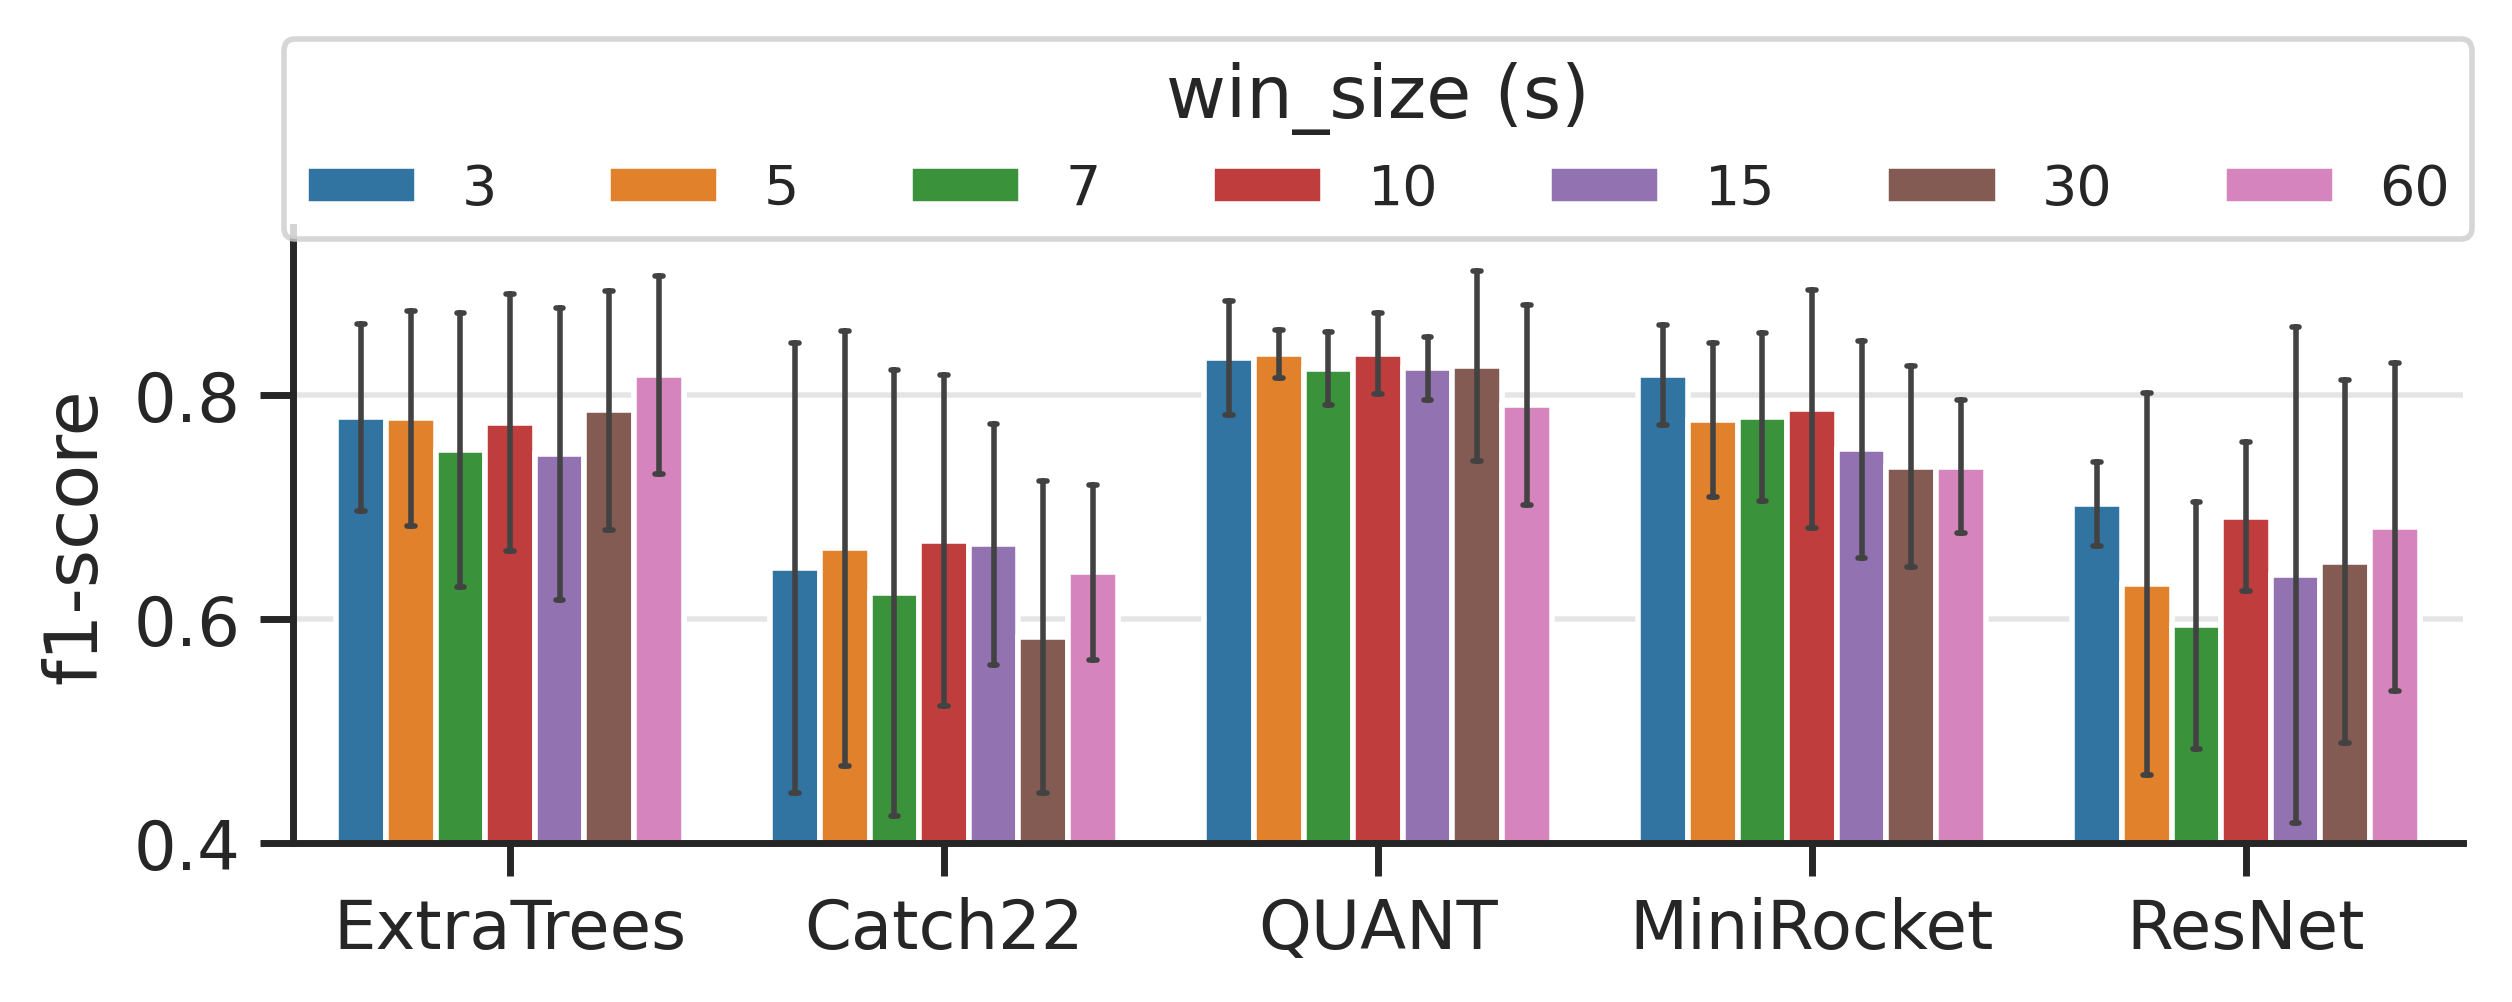

In [16]:
from scripts.plotting import window_bar

plt.figure(figsize=(7, 2), dpi=400)
ax = window_bar(real_cv_metrics.query("seed==0.0"),
                metric="f1-score", ci="sd",
                x="model", hue="window_size")
ax.set_xlabel("")
ax.set_title("")
ax.set_ylim(0.4, 0.95)
ax.grid(axis='y', alpha=0.5, which='both')
ax.legend(loc=9, ncol=7, 
          title="win_size (s)",
          bbox_to_anchor=(0.5, 1.35),
          fontsize=10)
ax.set_title("")
plt.savefig(FIG_DIR / "bar_plot_by_window_size.pdf", bbox_inches='tight')
plt.show()

In [26]:
# aggregate metrics
agg_metrics = aggregate(real_cv_metrics)
agg_metrics.to_csv(RES_DIR / "agg_metrics.csv", index=False)

In [17]:
grps = real_cv_metrics.groupby(['model', 'window_size']).mean(numeric_only=True)
# pick best model and window size
best_model = grps['f1-score'].idxmax()[0]
best_window = grps['f1-score'].idxmax()[1]
print(f"Best model: {best_model} with window size of {best_window} seconds")

Best model: QUANT with window size of 10 seconds


In [18]:
grps.sort_values(by='f1-score', ascending=False)

seed     runtime      delay  precision    recall  \
model      window_size                                                     
QUANT      10            0.0    5.192498   1.172980   0.795237  0.886058   
           5             0.0    3.140987   1.589703   0.806687  0.872039   
           3             0.0    2.430006   1.386971   0.791511  0.883804   
           30            0.0    8.710477  -1.614651   0.778090  0.883804   
           15            0.0    6.409637   1.125930   0.777228  0.880176   
           7             0.0    4.341904   1.079148   0.778022  0.878607   
ExtraTrees 60            0.0    0.803993  -2.691201   0.796139  0.852404   
MiniRocket 3             0.0    1.207917   1.872164   0.801848  0.838327   
QUANT      60            0.0   11.058853  -0.555033   0.777646  0.813431   
MiniRocket 10            0.0    1.416639  -0.279676   0.719619  0.883862   
ExtraTrees 30            0.0    0.475816   3.304373   0.767111  0.814920   
MiniRocket 7             0.0    1.344564   0.972139   0.726193  0.858786   
ExtraTrees 3             0.0    0.147225   3.700849   0.797870  0.775123   
           5             0.0    0.161851   2.310668   0.771245  0.802953   
MiniRocket 5             0.0    1.298410   1.677520   0.724428  0.849138   
ExtraTrees 10            0.0    0.222085   3.252947   0.777059  0.776965   
MiniRocket 15            0.0    1.374075  -1.376427   0.666987  0.871287   
ExtraTrees 7             0.0    0.186128   3.772950   0.751744  0.761992   
           15            0.0    0.282191   3.338154   0.733722  0.769796   
MiniRocket 30            0.0    2.004875 -14.168402   0.649825  0.863150   
           60            0.0    2.933554 -36.962532   0.645121  0.865760   
ResNet     3             0.0    2.078723   5.306819   0.769743  0.667630   
           10            0.0    2.782215  -3.136067   0.629762  0.809732   
           60            0.0   10.213289 -25.229305   0.777458  0.637240   
Catch22    10            0.0   15.943712   1.583816   0.561632  0.845856   
           15            0.0   25.200988  -2.865087   0.548840  0.870124   
           5             0.0   10.027680   3.282085   0.598356  0.765778   
ResNet     30            0.0    6.363762  -9.797323   0.657778  0.675142   
Catch22    3             0.0    5.909346   3.013948   0.569058  0.774392   
           60            0.0  123.045757 -41.933273   0.536829  0.810222   
ResNet     15            0.0    3.637050  -6.426927   0.581463  0.734056   
           5             0.0    2.252937  -2.117122   0.507400  0.862464   
Catch22    7             0.0   12.773638   3.398071   0.553820  0.749798   
ResNet     7             0.0    2.315364   0.829131   0.548170  0.712376   
Catch22    30            0.0   51.103485 -12.510858   0.474412  0.799751   

                        specificity  f1-score       auc  false alarm rate  \
model      window_size                                                      
QUANT      10              0.999998  0.837197  0.943028          0.696136   
           5               0.999998  0.836736  0.936019          0.634739   
           3               0.999998  0.833422  0.941901          0.712789   
           30              0.999998  0.826164  0.941901          0.788431   
           15              0.999998  0.823985  0.940087          0.773034   
           7               0.999998  0.823687  0.939303          0.763517   
ExtraTrees 60              0.999998  0.817998  0.926201          0.711969   
MiniRocket 3               0.999998  0.817945  0.919163          0.637495   
QUANT      60              0.999998  0.791294  0.906714          0.766296   
MiniRocket 10              0.999997  0.787875  0.941929          1.144961   
ExtraTrees 30              0.999998  0.786622  0.907459          0.791122   
MiniRocket 7               0.999997  0.780786  0.929391          1.083323   
ExtraTrees 3               0.999998  0.780479  0.887561          0.631970   
           5               0.999998  0.779483  0.901475 

In [33]:
# use multiple comparison matrix from aeon
from aeon.visualisation import create_multi_comparison_matrix

pivots = real_cv_metrics.pivot_table(
    index='fold',
    columns='model',
	values='f1-score',
    aggfunc='mean'
)
pivots

model,Catch22,ExtraTrees,MiniRocket,QUANT,ResNet
fold,,,,,
1,0.683856,0.934002,0.802009,0.854347,0.626868
2,0.771202,0.815350,0.855558,0.866292,0.788095
3,0.455554,0.698955,0.686897,0.798997,0.612930
4,0.738308,0.693970,0.751888,0.832795,0.673831
5,0.561880,0.742415,0.752644,0.770772,0.579685


In [ ]:
create_multi_comparison_matrix(
    pivots, used_statistic='F1-score',
    #    win_label='wins',
    #    loss_label='losses',
    #    tie_label='ties',
    font_size=20.5,
    fig_size="17,10",
    pdf_savename=FIG_DIR / "multi_comparison_matrix.pdf"
)
plt.show()

### Cost Sensitive Threshold Tuning

In [21]:
best_windows = json.load(open(RES_DIR/"best_window_size.json", "r"))
win_sizes = set([best_windows[m.name] for m in MODEL_SPECS\
                  if m.kind != "baseline"\
                    and "Ensemble" not in m.name\
                        and m.name != "ResNet"])
# create datasets for each window size
whole_df = fs.load()
datasets = {}
for win in win_sizes:
    datasets[win] = utils.split_df(
		whole_df, fs, test_set=TEST_SUBJ,
        window_size=win, segment_test=False,
        thresh=1.4, multiphase=True
	)

Train set: 124 samples, Test set: 21 samples
Train set: X: (1213, 1000), y: (1213,)    ([ADLs, Falls]) [1089  124]
Test set: X: 21, y: 21
Train set: 124 samples, Test set: 21 samples
Train set: X: (1271, 300), y: (1271,)    ([ADLs, Falls]) [1147  124]
Test set: X: 21, y: 21
Train set: 124 samples, Test set: 21 samples
Train set: X: (1039, 6000), y: (1039,)    ([ADLs, Falls]) [915 124]
Test set: X: 21, y: 21


In [23]:
from scripts.model_runner import run_models

thresh_metrics = []
quant = get_model_specs(subset=['QUANT'])
for t in [False, True]:
	for win in [10]:
		print(f"Running models for window size {win} seconds, thresh={t}")
		X_tr, X_te, y_tr, y_te = datasets[win]
		res = run_models(
			X_tr, X_te, y_tr, y_te,
			model_specs=quant,
			model_seeds=SEEDS,
			verbose=True,
			ensemble_models=False,
			ensemble_by_kind=False,
			window_size=win,
			tune_threshold=t
		)
		res["window_size"] = win
		thresh_metrics.append(res)
		print("")
thresh_df = pd.concat(thresh_metrics, ignore_index=True)

2025-08-05 23:22:48,622 [INFO] Training models (seed=0)


Running models for window size 10 seconds, thresh=False


Training (seed=0): 100%|██████████| 1/1 [00:08<00:00,  8.29s/it]
2025-08-05 23:22:56,921 [INFO] Training models (seed=1)
Training (seed=1): 100%|██████████| 1/1 [00:08<00:00,  8.08s/it]
2025-08-05 23:23:05,005 [INFO] Training models (seed=2)
Evaluating models: 100%|██████████| 3/3 [00:35<00:00, 11.67s/it]
2025-08-05 23:23:48,224 [INFO] ✅ Evaluation complete
2025-08-05 23:23:48,226 [INFO] Training models (seed=0)



Running models for window size 10 seconds, thresh=True


Training (seed=0): 100%|██████████| 1/1 [00:47<00:00, 47.87s/it]
2025-08-05 23:24:36,098 [INFO] Training models (seed=1)
Training (seed=1): 100%|██████████| 1/1 [00:08<00:00,  8.07s/it]
2025-08-05 23:24:44,171 [INFO] Training models (seed=2)
Evaluating models: 100%|██████████| 3/3 [00:35<00:00, 11.67s/it]
2025-08-05 23:25:27,339 [INFO] ✅ Evaluation complete


In [36]:
# thresh_df = pd.read_csv(RES_DIR / "thresh_metrics.csv")
thresh_df.sort_values(by=["model", "seed", "thresh"])
thresh_df.to_csv(RES_DIR / "quant_thresh_metrics.csv", index=False)

In [40]:
from scripts.model_runner import run_models

thresh_metrics = []
baselines = get_model_specs(kind="baseline")
for t in [False, True]:
	for win in win_sizes:
		print(f"Running models for window size {win} seconds, thresh={t}")
		# Select models for this window size
		models = [m for m in MODEL_SPECS
			 if m.kind != "baseline" and m.name != "ResNet"\
				  and best_windows[m.name] == win]
		if not t and models != []:
			models += baselines
		print(f"Selected models: {[m.name for m in models]}")
		X_tr, X_te, y_tr, y_te = datasets[win]
		res = run_models(
			X_tr, X_te, y_tr, y_te,
			model_specs=models,
			model_seeds=SEEDS,
			verbose=True,
			ensemble_models=False,
			ensemble_by_kind=False,
			window_size=win,
			tune_threshold=t
		)
		res["window_size"] = win
		thresh_metrics.append(res)
		print("\n")
thresh_df = pd.concat(thresh_metrics, ignore_index=True)
thresh_df.to_csv(RES_DIR / "thresh_metrics_new.csv", index=False)

2025-08-06 00:51:14,211 [INFO] Training models (seed=0)


Running models for window size 10 seconds, thresh=False
Selected models: ['Catch22', 'QUANT', 'DummyADL', 'DummyFall']


Training (seed=0): 100%|██████████| 4/4 [00:10<00:00,  2.71s/it]
2025-08-06 00:51:25,060 [INFO] Training models (seed=1)
Training (seed=1): 100%|██████████| 4/4 [00:10<00:00,  2.72s/it]
2025-08-06 00:51:35,951 [INFO] Training models (seed=2)
Evaluating models: 100%|██████████| 8/8 [02:30<00:00, 18.81s/it]
2025-08-06 00:54:17,097 [INFO] ✅ Evaluation complete
2025-08-06 00:54:17,102 [INFO] Training models (seed=0)




Running models for window size 3 seconds, thresh=False
Selected models: ['MiniRocket', 'DummyADL', 'DummyFall']


Training (seed=0): 100%|██████████| 3/3 [00:01<00:00,  2.90it/s]
2025-08-06 00:54:18,137 [INFO] Training models (seed=1)
Training (seed=1): 100%|██████████| 3/3 [00:00<00:00,  5.45it/s]
2025-08-06 00:54:18,688 [INFO] Training models (seed=2)
Evaluating models: 100%|██████████| 5/5 [00:09<00:00,  1.84s/it]
2025-08-06 00:54:28,473 [INFO] ✅ Evaluation complete
2025-08-06 00:54:28,476 [INFO] Training models (seed=0)




Running models for window size 60 seconds, thresh=False
Selected models: ['ExtraTrees', 'DummyADL', 'DummyFall']


Training (seed=0): 100%|██████████| 3/3 [00:03<00:00,  1.16s/it]
2025-08-06 00:54:31,949 [INFO] Training models (seed=1)
Training (seed=1): 100%|██████████| 3/3 [00:03<00:00,  1.14s/it]
2025-08-06 00:54:35,364 [INFO] Training models (seed=2)
Evaluating models: 100%|██████████| 5/5 [00:04<00:00,  1.14it/s]
2025-08-06 00:54:43,274 [INFO] ✅ Evaluation complete
2025-08-06 00:54:43,276 [INFO] Training models (seed=0)




Running models for window size 10 seconds, thresh=True
Selected models: ['Catch22', 'QUANT']


Training (seed=0): 100%|██████████| 2/2 [01:08<00:00, 34.11s/it]
2025-08-06 00:55:51,491 [INFO] Training models (seed=1)
Training (seed=1): 100%|██████████| 2/2 [00:10<00:00,  5.48s/it]
2025-08-06 00:56:02,450 [INFO] Training models (seed=2)
Evaluating models: 100%|██████████| 6/6 [02:50<00:00, 28.37s/it]
2025-08-06 00:59:03,827 [INFO] ✅ Evaluation complete
2025-08-06 00:59:03,830 [INFO] Training models (seed=0)




Running models for window size 3 seconds, thresh=True
Selected models: ['MiniRocket']


Training (seed=0): 100%|██████████| 1/1 [00:04<00:00,  4.62s/it]
2025-08-06 00:59:08,454 [INFO] Training models (seed=1)
Training (seed=1): 100%|██████████| 1/1 [00:00<00:00,  1.84it/s]
2025-08-06 00:59:09,000 [INFO] Training models (seed=2)
Evaluating models: 100%|██████████| 3/3 [00:09<00:00,  3.08s/it]
2025-08-06 00:59:18,809 [INFO] ✅ Evaluation complete
2025-08-06 00:59:18,811 [INFO] Training models (seed=0)




Running models for window size 60 seconds, thresh=True
Selected models: ['ExtraTrees']


Training (seed=0): 100%|██████████| 1/1 [00:20<00:00, 20.27s/it]
2025-08-06 00:59:39,087 [INFO] Training models (seed=1)
Training (seed=1): 100%|██████████| 1/1 [00:03<00:00,  3.43s/it]
2025-08-06 00:59:42,516 [INFO] Training models (seed=2)
Evaluating models: 100%|██████████| 3/3 [00:04<00:00,  1.39s/it]
2025-08-06 00:59:50,222 [INFO] ✅ Evaluation complete


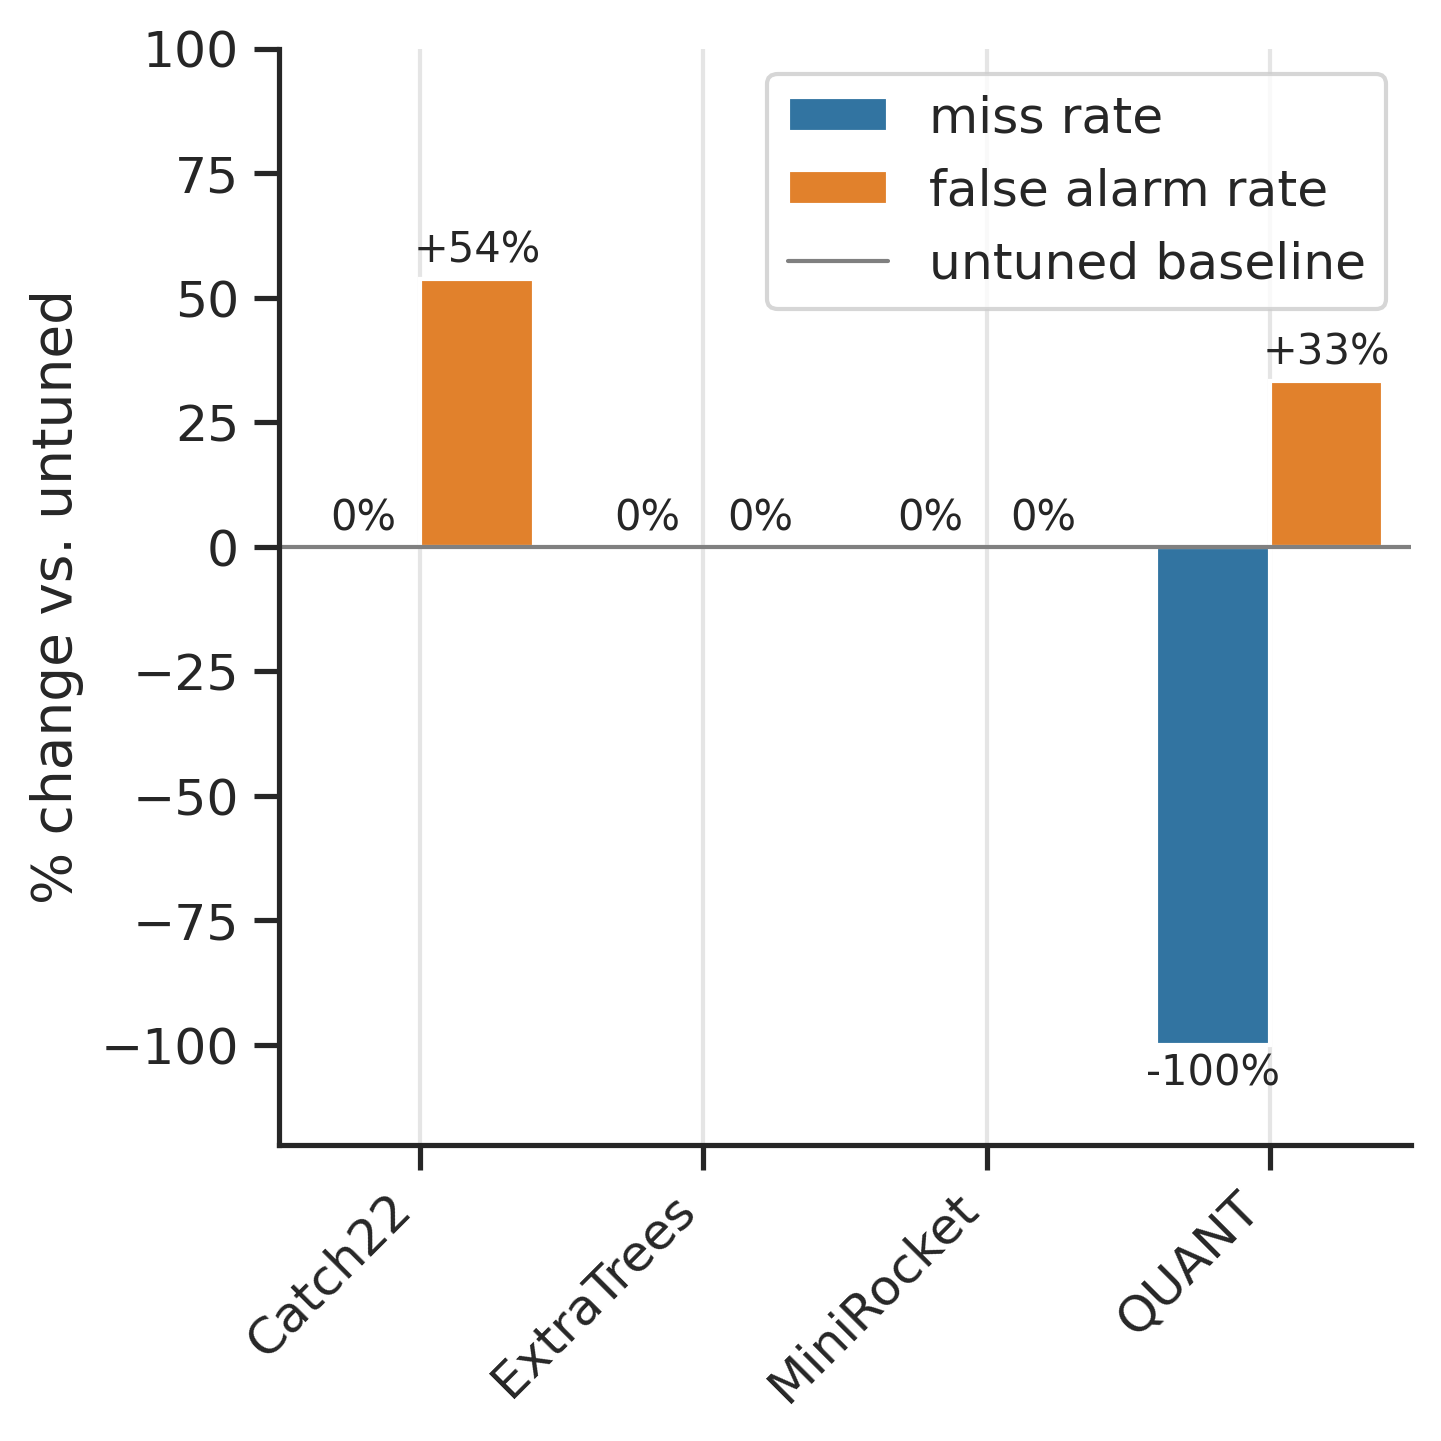

In [64]:
metrics = ["miss rate", "false alarm rate"]
real_thresh_df = thresh_df.query("not model.str.startswith('Dummy')")
records = []
for model, g in real_thresh_df.groupby("model"):
    # g = g.query("seed==0")
    base = g.query("thresh==0.5")  
    tuned = g.query("thresh!=0.5")
    for m in metrics:
        v0 = base[m].values[0]
        v1 = tuned[m].values[0]
        pct = 100 * (v1 - v0) / v0         # +% worse, −% better
        records.append({"model": model, "metric": m, "pct": pct})
delta_df = pd.DataFrame(records)

fig, ax = plt.subplots(figsize=(5, 5), dpi=300)
sns.barplot(data=delta_df, x="model", y="pct", hue="metric",
            palette="tab10", errorbar=None, ax=ax)
# zero-line & label
ax.axhline(0, color="gray", linewidth=1, label="untuned baseline")

# annotate % on every bar
for container in ax.containers:
    for bar in container:
        height = bar.get_height()
        txt = f"{height:+.0f}%"
        if height == 0:
            txt = "0%"
        ax.text(bar.get_x() + bar.get_width()/2,
                height + (1.5 if height>=0 else -1.5),   # small offset
                txt, ha="center", va="bottom" if height>=0 else "top",
                fontsize=10)
ax.set_ylim(-120, 100)  # set y-axis limits
ax.set_ylabel("% change vs. untuned")
ax.set_xlabel("")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
ax.legend()
ax.grid(axis='x', alpha=0.5, which='both')
sns.despine()
plt.tight_layout()
plt.savefig(FIG_DIR / "tuning.pdf", bbox_inches='tight')
plt.show()

In [63]:
mean_thresh = real_thresh_df.groupby(["model", "thresh"]).mean(numeric_only=True)
std_thresh = real_thresh_df.groupby(["model", "thresh"]).std(numeric_only=True)
# get a df with each mean value +/- std
mean_thresh = mean_thresh.round(2)
std_thresh = std_thresh.round(2)
for col in mean_thresh.columns:
	mean_thresh[col] = mean_thresh[col].astype(str) + " $\pm$ " + std_thresh[col].astype(str)
mean_thresh.to_csv(RES_DIR / "agg_thresh_metrics.csv", index=True)

seed  window_size   runtime     delay  precision  \
model      thresh                                                       
Catch22    0.378182   1.0          0.0  0.017296  1.602389   0.022995   
           0.500000   1.0          0.0  0.010467  0.577350   0.009878   
ExtraTrees 0.484848   1.0          0.0  0.001876  0.000000   0.049561   
           0.500000   1.0          0.0  0.002533  0.329914   0.049561   
MiniRocket 0.010101   1.0          0.0  0.008770  0.000000   0.000000   
           0.500000   1.0          0.0  0.003884  0.000000   0.000000   
QUANT      0.414141   1.0          0.0  0.073645  0.756429   0.000000   
           0.500000   1.0          0.0  0.028004  0.125988   0.021679   

                       recall   specificity  f1-score           auc  \
model      thresh                                                     
Catch22    0.378182  0.027493  4.606097e-07  0.025982  1.374667e-02   
           0.500000  0.027493  2.303048e-07  0.012357  1.374638e-02   
ExtraTrees 0.484848  0.000000  3.990668e-07  0.021055  1.995334e-07   
           0.500000  0.000000  3.990668e-07  0.021055  1.995334e-07   
MiniRocket 0.010101  0.000000  0.000000e+00  0.000000  0.000000e+00   
           0.500000  0.000000  0.000000e+00  0.000000  0.000000e+00   
QUANT      0.414141  0.000000  0.000000e+00  0.000000  0.000000e+00   
           0.500000  0.000000  2.303048e-07  0.011596  1.151524e-07   

                     false alarm rate  miss rate          gain  
model      thresh                                               
Catch22    0.378182          0.165806   0.082903  1.597976e-12  
           0.500000          0.082903   0.082903  8.478157e-13  
ExtraTrees 0.484848          0.143592   0.000000  5.519218e-13  
           0.500000          0.143592   0.000000  5.519218e-13  
MiniRocket 0.010101          0.000000   0.000000  0.000000e+00  
           0.500000          0.000000   0.000000  0.000000e+00  
QUANT      0.414141          0.000000   0.000000  0.000000e+00  
           0.500000          0.082903   0.000000  3.185156e-13